In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Hyperparam

In [2]:
C,H,W = 3, 320, 480

device = 'cpu'

In [3]:
def t2i(o):
    o = o.detach().cpu()
    o = o.permute(1,2,0)
    return Image.fromarray(np.array(o).astype(np.uint8))

def drawCircle(img, r, coord,color='blue'):
    img = img.copy()
    h, w = coord
    draw = ImageDraw.Draw(img)
    draw.ellipse((w-r, h-r, w+r, h+r), fill = color)
    return img

def drawRect(img, size, coord, color='blue'):
    img = img.copy()
    h, w = coord
    Lh, Lw = size
    draw = ImageDraw.Draw(img)
    draw.rectangle((w-(Lw/2), h-(Lh/2), w+(Lw/2), h+(Lh/2)), fill = color)
    return img

def drawCircle(img, D, coord, color='blue'):
    r = D/2
    img = img.copy()
    h, w = coord
    draw = ImageDraw.Draw(img)
    draw.ellipse((w-r, h-r, w+r, h+r), fill = color)
    return img

# Draw world

In [4]:
def draw_world(obj, goal):
    objL = 50
    goalL = 70
    o = torch.zeros(C, H, W)
    img = t2i(o)
    img = drawRect(img, (goalL,goalL), (goal[0],goal[1]), 'green')
    img = drawCircle(img, objL, (obj[0],obj[1]), 'red')
    return img

# Init Model

In [5]:
#https://pytorch.org/hub/pytorch_vision_fcn_resnet101/
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=False)
model.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size = (1,1), stride = (1,1))
model = model.to(device)

Using cache found in /home/hw/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
lr = 1e-3

# Optimizer
params = model.parameters()

optimizer = torch.optim.Adam(params, 
                             lr=lr,
                             betas=(0.9, 0.98),
                             eps=1e-09, 
                             weight_decay=1e-4, 
                             amsgrad=True)

# Collect demo

In [7]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
n_demos = 1

In [9]:
demos = []

for _ in range(n_demos):
    offset = 0.1
    
    obj = (torch.rand(2) * (1 - 2*offset) + offset) * torch.tensor([H,W])
    #goal = (torch.rand(2) * (1 - 2*offset) + offset) * torch.tensor([H,W])
    goal = torch.tensor([0.8, 0.8]) * torch.tensor([H,W])
    img = draw_world(obj, goal)
    
    demos.append({'img':img, 
                  'o':preprocess(img),
                  'obj':obj,
                  'goal':goal})

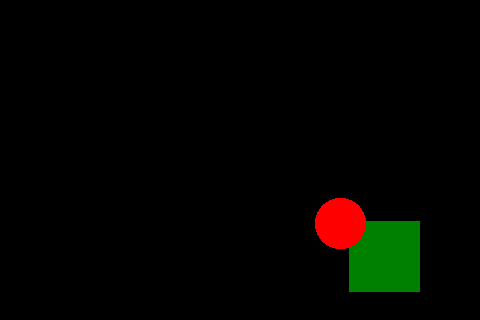

In [10]:
demos[0]['img']

# Prepare Input

In [11]:
Os = []
targets = []

for demo in demos:
    Os.append(demo['o'])
    targets.append(demo['obj'].type(torch.int64))
    
Os = torch.stack(Os,axis=0).to(device)
targets = torch.stack(targets,axis=0).to(device)

# Train

In [12]:
optimizer.zero_grad()

In [13]:
t = model(Os)['out'].squeeze(1)

In [14]:
V = F.log_softmax(t.view(t.shape[0],-1),dim=-1).reshape(t.shape)

In [15]:
Vh = V.gather(dim=1, index=targets[:,0].unsqueeze(-1).unsqueeze(-1).expand(-1,1,W))

In [16]:
V_targets = Vh.squeeze(1).gather(dim=1, index=targets[:,1].unsqueeze(-1).type(torch.int64))

In [17]:
loss = (-1 * V_targets.mean())

In [18]:
loss.backward()

In [19]:
optimizer.step()

# Test

In [20]:
n_tests = 5

test_demos = []

for _ in range(n_tests):
    offset = 0.1
    
    obj = (torch.rand(2) * (1 - 2*offset) + offset) * torch.tensor([H,W])
    #goal = (torch.rand(2) * (1 - 2*offset) + offset) * torch.tensor([H,W])
    goal = torch.tensor([0.8, 0.8]) * torch.tensor([H,W])
    img = draw_world(obj, goal)
    
    test_demos.append({'img':img, 
                  'o':preprocess(img),
                  'obj':obj,
                  'goal':goal})

In [21]:
o_test = []
gt = []

for demo in test_demos:
    o_test.append(demo['o'])
    gt.append(demo['obj'].type(torch.int64))
    
o_test = torch.stack(o_test,axis=0).to(device)
gt = torch.stack(gt,axis=0).to(device)

In [22]:
with torch.no_grad():
    t_test = model(o_test)['out'].squeeze(1)
    V = F.softmax(t_test.view(t_test.shape[0],-1),dim=-1).reshape(t_test.shape)

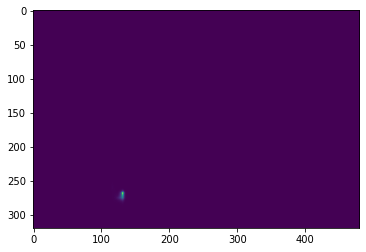

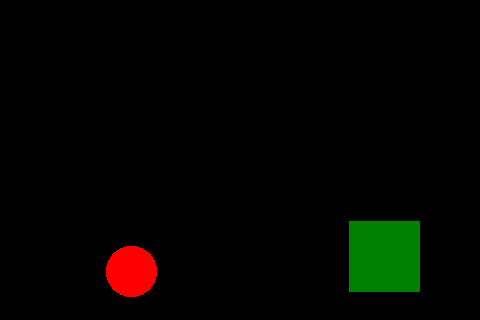

In [27]:
test_idx = 4
plt.imshow(V[test_idx].detach().numpy())
plt.show()
test_demos[test_idx]['img']